# ta-lib-008 ( Feature‑Engineering + Sequence Models)
https://chatgpt.com/c/680d231a-52f4-800a-a105-9f5bfe49fca1

What's new:

1-

# Load your historical Forex data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks

2025-05-05 20:10:34.304720: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746463234.319009   13577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746463234.323876   13577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 20:10:34.337583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# PARAMETERS
DATA_PATH = 'datasets/XAGUSD-H1-rates.csv'   # Path to your historical Forex data CSV
MODEL_SAVE_PATH = 'lstm_forex_model.h5'
WINDOW_SIZE = 30              # Number of past candles used as input
FORECAST_HORIZON = 10         # Number of future candles to predict
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 0.001
TEST_SIZE = 0.2               # % of data for validation
TARGET_COLUMN = '<CLOSE>'       # Which price to predict: '<CLOSE>', 'open', etc.

In [4]:

df = pd.read_csv(DATA_PATH, sep='\t')

# Basic cleaning if necessary
df = df.dropna()
# Feature Engineering (TA-Lib indicators)
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_10'] = talib.EMA(df['<CLOSE>'], timeperiod=10)
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df = df.dropna()
    return df


df = add_ta_features(df)
# Scaling Features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_10', 'ema_50', 'atr', 'adx']])
def create_sequences(features, target, window_size, forecast_horizon):
    X, y = [], []
    for i in range(window_size, len(features) - forecast_horizon):
        X.append(features[i-window_size:i])
        y.append(target[i:i+forecast_horizon])
    return np.array(X), np.array(y)

# Prepare data
target_data = df[TARGET_COLUMN].values
X, y = create_sequences(scaled_features, target_data, WINDOW_SIZE, FORECAST_HORIZON)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle=False)
def build_model(input_shape, forecast_horizon, learning_rate):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(forecast_horizon)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

model = build_model((X_train.shape[1], X_train.shape[2]), FORECAST_HORIZON, LEARNING_RATE)
# Training model
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[es]
)
# Predict
y_pred = model.predict(X_test)


I0000 00:00:1746463242.449304   13577 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2284 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/saeed/repositories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2


2025-05-05 20:10:43.172156: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58073400 exceeds 10% of free system memory.
2025-05-05 20:10:43.207283: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 58073400 exceeds 10% of free system memory.
I0000 00:00:1746463244.960623   14157 cuda_dnn.cc:529] Loaded cuDNN version 90800


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 122.6534 - val_loss: 23.0695
Epoch 2/2
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 18.1381 - val_loss: 22.6920
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


# plot section

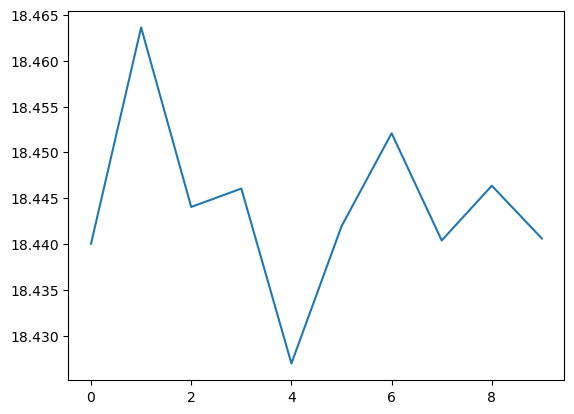

In [5]:
plt.plot(range(10), y_pred[0])
plt.show()


In [6]:
from utils import forex_plot_utils

In [14]:
# LOAD DATA
predicted_df = forex_plot_utils.load_csv_with_datetime(csv2_path)


# PLOT
forex_plot_utils.plot_all_series(
    predicted_df=predicted_df,
)

NameError: name 'forex_plot_utils' is not defined